In [ ]:
import os
os.kill(os.getpid(), 9)


In [1]:
from google.colab import drive
drive.mount('/content/drive')
DATASET_PATH = "/content/drive/MyDrive/accent_dataset" # Dataset path

!pip install librosa
!pip install yt-dlp
!pip install ffmpeg-python
!pip install pyannote.audio
!pip install openai-whisper
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 37.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.1/864.1 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [2]:
!pip install pydub

import os
import whisper
from pydub import AudioSegment
from pydub.utils import make_chunks

In [ ]:
!pip install pydub

import os
import whisper
from pydub import AudioSegment
from pydub.utils import make_chunks

# Load Whisper model
model = whisper.load_model("base")

# Paths
SOURCE_DIR = "/content/drive/MyDrive/accent_dataset"
CLEANED_DIR = "/content/drive/MyDrive/CleanSegments"
os.makedirs(CLEANED_DIR, exist_ok=True)

# Function to extract segments
def extract_segments(audio_path, accent_label, min_duration=3.0):
    result = model.transcribe(audio_path, verbose=False)
    segments = result.get("segments", [])
    base_name = os.path.splitext(os.path.basename(audio_path))[0]
    audio = AudioSegment.from_file(audio_path)

    accent_folder = os.path.join(CLEANED_DIR, accent_label)
    os.makedirs(accent_folder, exist_ok=True)

    count = 0
    for seg in segments:
        start_ms = int(seg['start'] * 1000)
        end_ms = int(seg['end'] * 1000)
        if seg['end'] - seg['start'] >= min_duration:
            chunk = audio[start_ms:end_ms]
            chunk.export(os.path.join(accent_folder, f"{base_name}_seg{count}.wav"), format="wav")
            count += 1

# Process all files
for accent in os.listdir(SOURCE_DIR):
    accent_path = os.path.join(SOURCE_DIR, accent)
    if not os.path.isdir(accent_path):
        continue
    for file in os.listdir(accent_path):
        if file.endswith(".wav"):
            extract_segments(os.path.join(accent_path, file), accent)


In [3]:
import os
import random
import numpy as np
import tensorflow as tf

# Set a global seed for reproducibility
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)


In [4]:
import os
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

DATASET_PATH = '/content/drive/MyDrive/CleanSegments'
SAMPLES_TO_CONSIDER = 22050 * 3  # 3 seconds

features = []
labels = []

# Traverse through accent subfolders
for accent in os.listdir(DATASET_PATH):
    accent_path = os.path.join(DATASET_PATH, accent)
    if not os.path.isdir(accent_path):
        continue

    for file in os.listdir(accent_path):
        if file.endswith(".wav"):
            file_path = os.path.join(accent_path, file)
            try:
                # Load audio
                y, sr = librosa.load(file_path, sr=22050, duration=3.0)

                # Pad or truncate to 3 seconds
                if len(y) < SAMPLES_TO_CONSIDER:
                    y = np.pad(y, (0, SAMPLES_TO_CONSIDER - len(y)))
                else:
                    y = y[:SAMPLES_TO_CONSIDER]

                # Extract MFCC
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
                features.append(mfcc.T)
                labels.append(accent.lower())

            except Exception as e:
                print(f"Error with {file_path}: {e}")


# balancing classe

In [5]:
from collections import defaultdict
import random

# Group by class
class_to_features = defaultdict(list)
for feature, label in zip(features, labels):
    class_to_features[label].append(feature)

# Get the target class size
max_samples = max(len(v) for v in class_to_features.values())
print("Target per class:", max_samples)

# Duplicate to balance
balanced_features = []
balanced_labels = []

for label, feats in class_to_features.items():
    extra_needed = max_samples - len(feats)
    if extra_needed > 0:
        feats += random.choices(feats, k=extra_needed)
    balanced_features.extend(feats)
    balanced_labels.extend([label] * len(feats))

print(f"Balanced features: {len(balanced_features)}")


Target per class: 218
Balanced features: 3270


In [6]:
print(len(features), len(labels))
print(type(features[0]), type(labels[0]))
print(np.array(features).shape)


1289 1289
<class 'numpy.ndarray'> <class 'str'>
(1289, 130, 40)


In [7]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

X = np.array(balanced_features)[..., np.newaxis]

le = LabelEncoder()
y_encoded = le.fit_transform(balanced_labels)
y = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (2616, 130, 40, 1) Test: (654, 130, 40, 1)


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, Reshape,
    Bidirectional, LSTM, MultiHeadAttention,
    GlobalAveragePooling1D, Dense
)

input_shape = (130, 40, 1)  # MFCC input shape

inputs = Input(shape=input_shape)

# CNN layers
x = Conv2D(32, (3,3), activation='relu')(inputs)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

# Reshape for RNN
x = Reshape((31*8, 64))(x)  # (None, 248, 64)

# BiLSTM
x = Bidirectional(LSTM(128, return_sequences=True))(x)

# MultiHeadAttention (self-attention)
attn_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x, x)

# Pooling to get fixed-length vector
x = GlobalAveragePooling1D()(attn_output)

# Fully connected layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(15, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 130, 40,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 38,   │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 19,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 19,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 62, 17,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 31, 8, 64) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 31, 8, 64) │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 248, 64)   │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 248, 256)  │    197,632 │ reshape[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 248, 256)  │    263,168 │ bidirectional[0]… │
│ (MultiHeadAttentio… │                   │            │ bidirectional[0]… │
│                     │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 15)        │      1,935 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 514,447 (1.96 MB)

 Trainable params: 514,447 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # for one-hot encoded labels
    metrics=['accuracy']
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import MultiHeadAttention


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_accent_model.h5',          # this will save the best weights to file
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

#  Include both callbacks
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


Epoch 1/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1064 - loss: 2.6292
Epoch 1: val_accuracy improved from -inf to 0.21254, saving model to best_accent_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.1068 - loss: 2.6282 - val_accuracy: 0.2125 - val_loss: 2.4171
Epoch 2/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3066 - loss: 2.1569
Epoch 2: val_accuracy improved from 0.21254 to 0.47095, saving model to best_accent_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.3071 - loss: 2.1552 - val_accuracy: 0.4709 - val_loss: 1.7433
Epoch 3/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4886 - loss: 1.5813
Epoch 3: val_accuracy improved from 0.47095 to 0.62997, saving model to best_accent_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.4890 - loss: 1.5803 - val_accuracy: 0.6300 - val_loss: 1.2582
Epoch 4/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6141 - loss: 1.2185
Epoch 4: val_accuracy improved from 0.62997 to 0.68502, saving model to best_accent_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.6141 - loss: 1.2180 - val_accuracy: 0.6850 - val_loss: 1.0088
Epoch 5/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6924 - loss: 0.9725
Epoch 5: val_accuracy improved from 0.68502 to 0.74006, saving model to best_accent_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.6923 - loss: 0.9728 - val_accuracy: 0.7401 - val_loss: 0.8830
Epoch 6/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7306 - loss: 0.8068
Epoch 6: val_accuracy improved from 0.74006 to 0.78135, saving model to best_accent_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.7306 - loss: 0.8068 - val_accuracy: 0.7813 - val_loss: 0.7419
Epoch 7/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7654 - loss: 0.7043
Epoch 7: val_accuracy improved from 0.78135 to 0.79052, saving model to best_accent_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.7654 - loss: 0.7044 - val_accuracy: 0.7905 - val_loss: 0.6731
Epoch 8/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8033 - loss: 0.6052
Epoch 8: val_accuracy improved from 0.79052 to 0.85321, saving model to best_accent_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.8033 - loss: 0.6050 - val_accuracy: 0.8532 - val_loss: 0.5188
Epoch 9/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8386 - loss: 0.4786
Epoch 9: val_accuracy improved from 0.85321 to 0.87003, saving model to best_accent_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.8385 - loss: 0.4788 - val_accuracy: 0.8700 - val_loss: 0.4637
Epoch 10/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8555 - loss: 0.4362
Epoch 10: val_accuracy did not improve from 0.87003
82/82 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.8555 - loss: 0.4365 - val_accuracy: 0.8609 - val_loss: 0.4677
Epoch 11/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8662 - loss: 0.4171
Epoch 11: val_accuracy improved from 0.87003 to 0.89602, saving model to best_accent_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.8663 - loss: 0.4169 - val_accuracy: 0.8960 - val_loss: 0.3867
Epoch 12/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8774 - loss: 0.3593
Epoch 12: val_accuracy improved from 0.89602 to 0.90673, saving model to best_accent_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.8775 - loss: 0.3593 - val_accuracy: 0.9067 - val_loss: 0.3420
Epoch 13/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8981 - loss: 0.2992
Epoch 13: val_accuracy did not improve from 0.90673
82/82 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.8981 - loss: 0.2993 - val_accuracy: 0.9052 - val_loss: 0.3916
Epoch 14/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8858 - loss: 0.3432
Epoch 14: val_accuracy did not improve from 0.90673
82/82 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.8858 - loss: 0.3430 - val_accuracy: 0.9052 - val_loss: 0.3351
Epoch 15/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9036 - loss: 0.2587
Epoch 15: val_accuracy did not improve from 0.90673
82/82 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9036 - loss: 0.2589 - val_accuracy: 0.8945 - val_loss: 0.3743
Epoch 16/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9064 - loss: 0.2759
Epoch 16: val_accuracy improved from 0.90673

82/82 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.9064 - loss: 0.2759 - val_accuracy: 0.9297 - val_loss: 0.2864
Epoch 17/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9262 - loss: 0.2052
Epoch 17: val_accuracy did not improve from 0.92966
82/82 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.9262 - loss: 0.2054 - val_accuracy: 0.9297 - val_loss: 0.2704
Epoch 18/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9299 - loss: 0.2273
Epoch 18: val_accuracy improved from 0.92966 to 0.94495, saving model to best_accent_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9298 - loss: 0.2275 - val_accuracy: 0.9450 - val_loss: 0.2305
Epoch 19/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9442 - loss: 0.1626
Epoch 19: val_accuracy improved from 0.94495 to 0.95107, saving model to best_accent_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.9442 - loss: 0.1627 - val_accuracy: 0.9511 - val_loss: 0.1836
Epoch 20/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9377 - loss: 0.1883
Epoch 20: val_accuracy did not improve from 0.95107
82/82 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9377 - loss: 0.1882 - val_accuracy: 0.9404 - val_loss: 0.2284
Epoch 21/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9514 - loss: 0.1496
Epoch 21: val_accuracy did not improve from 0.95107
82/82 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9513 - loss: 0.1499 - val_accuracy: 0.9281 - val_loss: 0.2812
Epoch 22/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9343 - loss: 0.1955
Epoch 22: val_accuracy did not improve from 0.95107
82/82 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9342 - loss: 0.1957 - val_accuracy: 0.9312 - val_loss: 0.2597
Epoch 23/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9505 - loss: 0.1569
Epoch 23: val_accuracy did not improve from 

82/82 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.9518 - loss: 0.1458 - val_accuracy: 0.9541 - val_loss: 0.2347


In [10]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict class probabilities
y_pred_prob = model.predict(X_test)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, digits=4))
print(confusion_matrix(y_true, y_pred))


21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 487ms/step
              precision    recall  f1-score   support

           0     0.8571    0.9545    0.9032        44
           1     1.0000    0.9302    0.9639        43
           2     1.0000    1.0000    1.0000        44
           3     0.9750    0.9070    0.9398        43
           4     0.9737    0.8409    0.9024        44
           5     1.0000    0.9767    0.9882        43
           6     0.9211    0.8140    0.8642        43
           7     0.9778    1.0000    0.9888        44
           8     1.0000    0.9318    0.9647        44
           9     1.0000    0.9535    0.9762        43
          10     0.7636    0.9545    0.8485        44
          11     0.9778    1.0000    0.9888        44
          12     1.0000    1.0000    1.0000        44
          13     0.9778    1.0000    0.9888        44
          14     0.9149    1.0000    0.9556        43

    accuracy                         0.9511       654
   macro avg     0.9559    0.9509    0

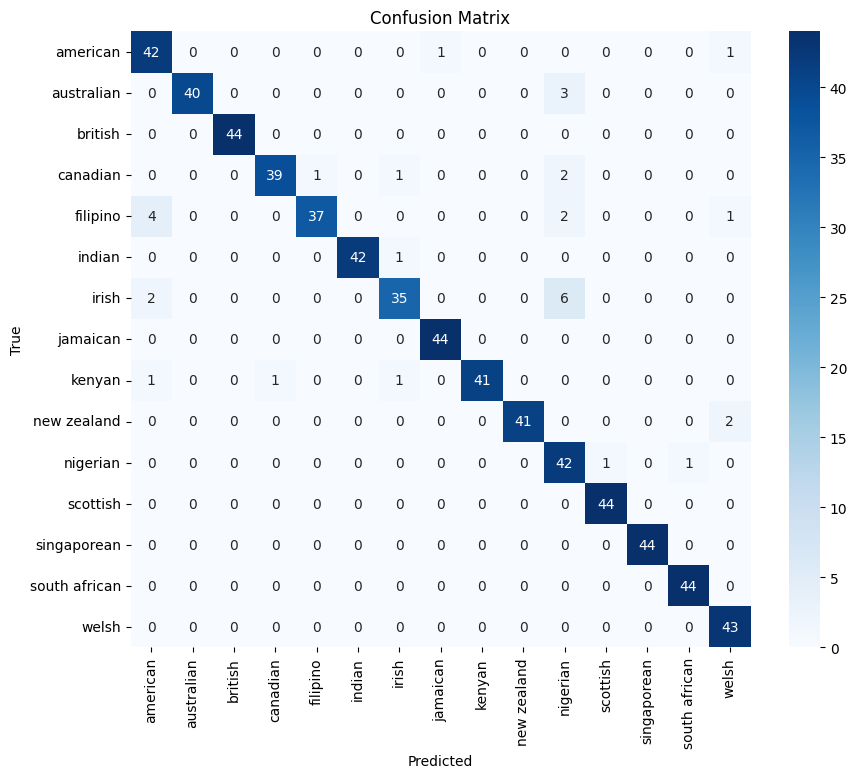

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get class labels
class_labels = le.classes_

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


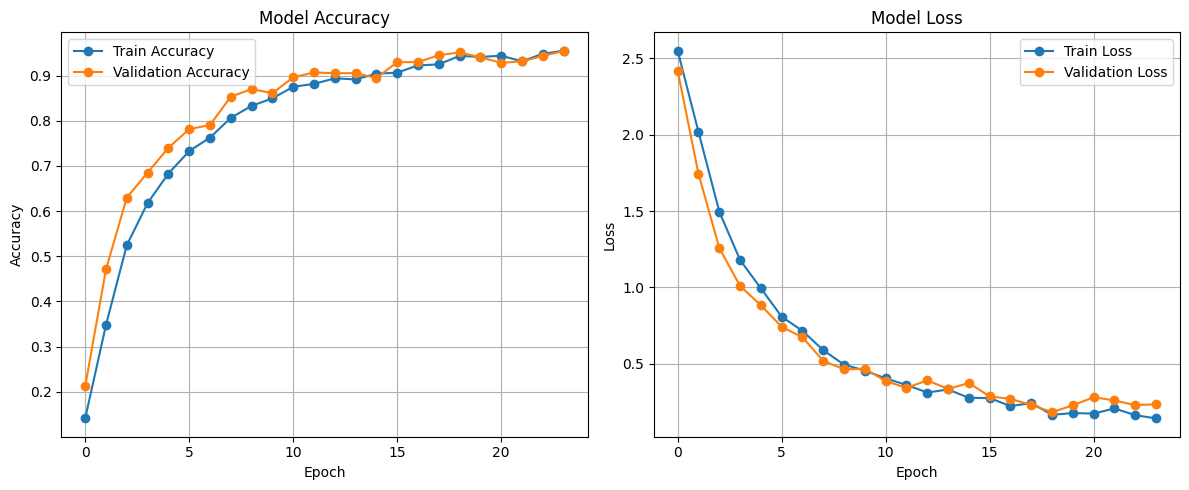

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# --- Accuracy Plot ---
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# --- Loss Plot ---
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_accuracy_loss_plot.png", dpi=300)  # Save to file
plt.show()


In [16]:
import os
import json
import pickle
import shutil
from tensorflow.keras.models import save_model

# --- Use correct label encoder variable ---
label_encoder = le  # You already used 'le' in training

# --- Class names list ---
class_names = [
    "American", "British", "Indian", "Australian", "Irish", "Canadian", "Scottish",
    "South African", "New Zealand", "Welsh", "Nigerian", "Singaporean", "Filipino",
    "Jamaican", "Kenyan"
]

# --- Create directory if not exists ---
os.makedirs("model_checkpoint", exist_ok=True)

# --- Save model in new recommended format ---
model.save("model_checkpoint/model.keras")  #
model.save("model_checkpoint/model.h5")

# --- Save class names as JSON ---
with open("model_checkpoint/class_names.json", "w") as f:
    json.dump(class_names, f)

# --- Save label encoder as pickle ---
with open("model_checkpoint/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# --- Save training history as pickle ---
with open("model_checkpoint/training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

# --- Zip the folder ---
shutil.make_archive("model_checkpoint", 'zip', "model_checkpoint")

print("Model, label encoder, class names, and training history saved and zipped successfully.")


Model, label encoder, class names, and training history saved and zipped successfully.


In [19]:
import os
import random
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle
import json

# --- CONFIGURATION ---
RAW_DATA_PATH = "/content/drive/MyDrive/accent_dataset"
MODEL_PATH = "/content/best_accent_model.h5"
ENCODER_PATH = "/content/model_checkpoint/label_encoder.pkl"
CLASS_NAMES_PATH = "/content/model_checkpoint/class_names.json"

SAMPLES_TO_CONSIDER = 22050 * 3  # 3 seconds
NUM_SAMPLES_TO_TEST = 30  # number of total files to test

# --- LOAD MODEL AND METADATA ---
model = load_model(MODEL_PATH)

with open(ENCODER_PATH, "rb") as f:
    label_encoder = pickle.load(f)

with open(CLASS_NAMES_PATH, "r") as f:
    class_names = json.load(f)

# --- SELECT RANDOM SAMPLES ---
sample_paths = []

for accent in os.listdir(RAW_DATA_PATH):
    accent_path = os.path.join(RAW_DATA_PATH, accent)
    if not os.path.isdir(accent_path):
        continue
    files = [os.path.join(accent_path, f) for f in os.listdir(accent_path) if f.endswith(".wav")]
    if files:
        selected = random.sample(files, min(len(files), 3))  # up to 3 files per accent
        sample_paths.extend([(f, accent) for f in selected])

random.shuffle(sample_paths)
sample_paths = sample_paths[:NUM_SAMPLES_TO_TEST]

# --- INFERENCE AND EVALUATION ---
correct = 0
total = 0
detailed_results = []

for path, true_label in sample_paths:
    try:
        y, sr = librosa.load(path, sr=22050, duration=3.0)
        if len(y) < SAMPLES_TO_CONSIDER:
            y = np.pad(y, (0, SAMPLES_TO_CONSIDER - len(y)))
        else:
            y = y[:SAMPLES_TO_CONSIDER]

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T
        mfcc = np.expand_dims(mfcc, axis=0)  # batch dimension
        mfcc = np.expand_dims(mfcc, axis=-1)  # channel dimension

        pred = model.predict(mfcc, verbose=0)
        pred_label_idx = np.argmax(pred)
        pred_label = label_encoder.inverse_transform([pred_label_idx])[0]

        is_correct = (pred_label.lower() == true_label.lower())
        if is_correct:
            correct += 1

        total += 1
        detailed_results.append((os.path.basename(path), true_label, pred_label, is_correct))

    except Exception as e:
        print(f"Error with file {path}: {e}")

# --- RESULTS ---
print(f"\nEvaluated on {total} samples.")
print(f"Correct Predictions: {correct}")
print(f"Incorrect Predictions: {total - correct}")
print(f"Accuracy: {100 * correct / total:.2f}%\n")

print("Detailed Results:")
for file, true_l, pred_l, status in detailed_results:
    status_text = "Yes" if status else "No"
    print(f"{file} | True: {true_l} | Predicted: {pred_l} | {status_text}")



Evaluated on 30 samples.
Correct Predictions: 26
Incorrect Predictions: 4
Accuracy: 86.67%

Detailed Results:
Two South African everyday life funnies .wav | True: South African | Predicted: south african | Yes
What Is Trevor_s Favorite Accent？ - Betw.wav | True: Kenyan | Predicted: american | No
＂ALWAYS UP＂ Kanye X Kid Cudi Type Beat -.wav | True: Scottish | Predicted: nigerian | No
Rebel Wilson Shares the Secret to Her Am.wav | True: American | Predicted: american | Yes
How to Introduce Yourself -- American En.wav | True: American | Predicted: american | Yes
Irish Farmers Glorious Accent Is So Stro.wav | True: Irish | Predicted: irish | Yes
Michael Sheen gives rousing speech for W.wav | True: Welsh | Predicted: welsh | Yes
Everyday British English Conversations (.wav | True: British | Predicted: british | Yes
Improving your accent： Drop your JAW mor.wav | True: Indian | Predicted: indian | Yes
Filipino Slip Accent Rankings ｜ Explorin.wav | True: Filipino | Predicted: irish | No
The W